In [4]:
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt 

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7.5)

# Part 1 ‐ Exploratory data analysis

In [34]:
df = pd.read_json(path_or_buf='logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [35]:
print('Overview:', df.describe())
print('Type:', df.dtypes)

Overview:                  login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38
Type: login_time    datetime64[ns]
dtype: object


In [36]:
df['login_time'] = pd.to_datetime(df['login_time'])
print(df['login_time'].dtypes)

datetime64[ns]


In [37]:
df = df.set_index('login_time').sort_index().resample('15T').size()

//anaconda3/envs/Springboard/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/envs/Springboard/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


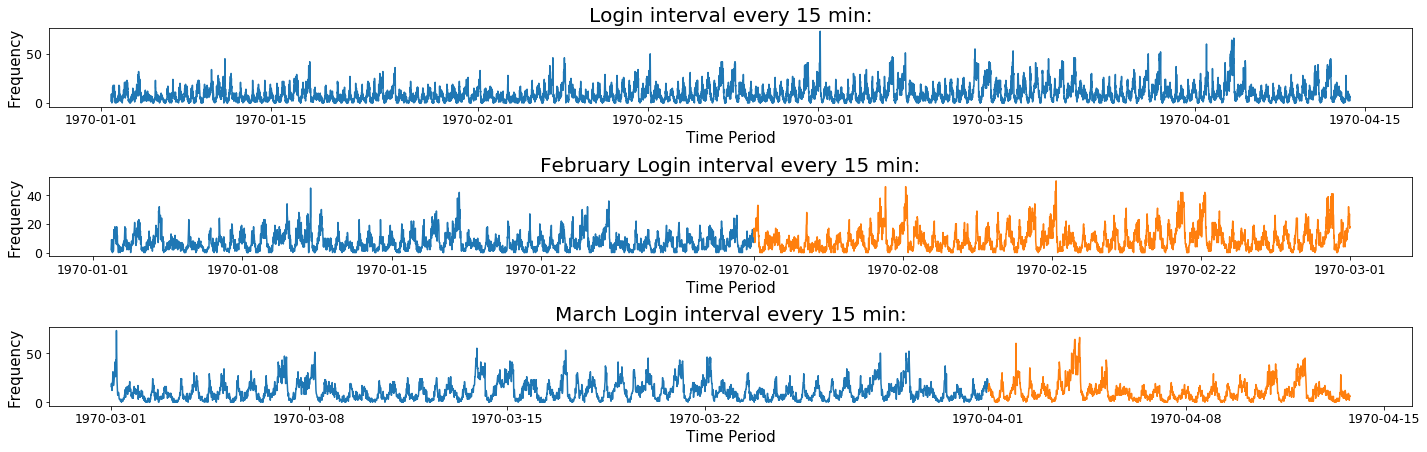

In [74]:
plt.figure(figsize=(20, 10))

plt.subplot(5, 1, 1)
plt.plot(df)
plt.title('Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 2)
plt.plot(df.loc['1970-01-01':'1970-01-31'])
plt.title('January Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 2)
plt.plot(df.loc['1970-02-01':'1970-02-28'])
plt.title('February Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 3)
plt.plot(df.loc['1970-03-01':'1970-03-31'])
plt.title('March Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 3)
plt.plot(df.loc['1970-04-01':'1970-04-30'])
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.tight_layout()
plt.show()

Busiest month of the year is February with a higher login average than the rest of the month. 

# Part 2 ‐ Experiment and metrics design

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Since driver partners already are more active depending on demand; we can reimburse the tolls to drivers partners when those cities are most active. In this example, we can reimburse Ultimate Metropolis during the day and Ultimate Gotham during the night; and both during the weekend. This will keep both partners in their respective times and encourage more drivers to join. 
We can also look at the peak time of demand for both cities and reimburse tolls during those specific peak times to encourage both city partners.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
First, narrow the riders that have at least 2+ rides in the last 30 days, preventing outliers or skewing our results. 
Second, compare which cities have the most riders and find the times these riders are booking rides.
Third, compare the times with the avg_surge and see if there is a correlation between the two.

    b. what statistical test(s) you will conduct to verify the significance of the observation

Assuming that our data is clean, I can use the different means from the results that are gathered from the riders; average time to find the peak times and correlate those with the avg_surge percentile.

    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    
I would start my test by reimbursing the tolls at peak times and see if that makes a difference for partners. Judging from those results, we can expand those times and test other times that are not as popular. Another starting point would be to start on weekends since the popularity is high in both cities and could help return results faster.

# Part 3 ‐ Predictive modeling

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
# from xgboost import XGBClassifier

In [5]:
with open('ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)
    
df2 = pd.DataFrame(data)
df2.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [7]:
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])
df2.dtypes

city                              object
trips_in_first_30_days             int64
signup_date                       object
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [8]:
retained = df2[df2['trips_in_first_30_days'] != 0]
retained.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34610 entries, 0 to 49998
Data columns (total 12 columns):
city                      34610 non-null object
trips_in_first_30_days    34610 non-null int64
signup_date               34610 non-null object
avg_rating_of_driver      30237 non-null float64
avg_surge                 34610 non-null float64
last_trip_date            34610 non-null datetime64[ns]
phone                     34292 non-null object
surge_pct                 34610 non-null float64
ultimate_black_user       34610 non-null bool
weekday_pct               34610 non-null float64
avg_dist                  34610 non-null float64
avg_rating_by_driver      34503 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 3.2+ MB


1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [9]:
print('Retained users: ', (len(retained)/len(df2))*100, '%')

Retained users:  69.22 %


2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [16]:
retained['signup_date'] = pd.to_datetime(retained['signup_date'])
retained['active'] = np.where(((retained['last_trip_date'] - retained['signup_date']) / np.timedelta64(1, 'M')) > 5, 1, 0)
print(retained.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34610 entries, 0 to 49998
Data columns (total 13 columns):
city                      34610 non-null object
trips_in_first_30_days    34610 non-null int64
signup_date               34610 non-null datetime64[ns]
avg_rating_of_driver      30237 non-null float64
avg_surge                 34610 non-null float64
last_trip_date            34610 non-null datetime64[ns]
phone                     34292 non-null object
surge_pct                 34610 non-null float64
ultimate_black_user       34610 non-null bool
weekday_pct               34610 non-null float64
avg_dist                  34610 non-null float64
avg_rating_by_driver      34503 non-null float64
active                    34610 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 3.5+ MB
None


//anaconda3/envs/Springboard/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/Springboard/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
active_users = retained[retained['active'] == 1]
active_users.info()
print('Active users: ', (len(active_users)/len(retained))*100, '%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8121 entries, 3 to 49993
Data columns (total 13 columns):
city                      8121 non-null object
trips_in_first_30_days    8121 non-null int64
signup_date               8121 non-null datetime64[ns]
avg_rating_of_driver      7868 non-null float64
avg_surge                 8121 non-null float64
last_trip_date            8121 non-null datetime64[ns]
phone                     8067 non-null object
surge_pct                 8121 non-null float64
ultimate_black_user       8121 non-null bool
weekday_pct               8121 non-null float64
avg_dist                  8121 non-null float64
avg_rating_by_driver      8120 non-null float64
active                    8121 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 832.7+ KB
Active users:  23.46431667148223 %


In [20]:
retained['ultimate_black_user'] = retained['ultimate_black_user'].astype(int)
retained.head()

//anaconda3/envs/Springboard/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,1,100.0,10.56,5.0,0


In [21]:
retained['phone'] = retained['phone'].fillna('Other')
retained['avg_rating_of_driver']
retained.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34610 entries, 0 to 49998
Data columns (total 13 columns):
city                      34610 non-null object
trips_in_first_30_days    34610 non-null int64
signup_date               34610 non-null datetime64[ns]
avg_rating_of_driver      30237 non-null float64
avg_surge                 34610 non-null float64
last_trip_date            34610 non-null datetime64[ns]
phone                     34610 non-null object
surge_pct                 34610 non-null float64
ultimate_black_user       34610 non-null int64
weekday_pct               34610 non-null float64
avg_dist                  34610 non-null float64
avg_rating_by_driver      34503 non-null float64
active                    34610 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(3), object(2)
memory usage: 3.7+ MB


//anaconda3/envs/Springboard/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
retained = pd.get_dummies(retained)
retained.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
retained.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,0,1,0,0,0,1
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0,0
5,2,3.5,1.00,0.0,1,100.0,10.56,5.0,0,0,0,1,0,0,1


In [27]:
X = retained.drop(['active'], axis=1)
y = retained['active']
print(X.shape, y.shape)

(34610, 14) (34610,)


In [39]:
def train_test_model(X, y, model, params, test_size=.2, random_state=32):
    
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model_cv = GridSearchCV(model, param_grid=params, cv=5)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    y_pred_prob = model_cv.predict_prob(X_test[:,1])
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

In [40]:
logreg = LogisticRegression()
c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possible C values
logreg_param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

train_test_model(X, y, logreg, logreg_param_grid)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').